In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv("Telco-Customer-Churn.csv")

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [7]:
# Convert TotalCharges (object → float)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Replace missing values
df["TotalCharges"].fillna(df["TotalCharges"].median(), inplace=True)

# Drop customerID (not useful)
df.drop("customerID", axis=1, inplace=True)


In [8]:
# Label encode binary columns
binary_cols = ["gender", "Partner", "Dependents", "PhoneService",
               "PaperlessBilling", "Churn"]

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

# One-hot encode non-binary columns
df = pd.get_dummies(df, drop_first=True)


In [9]:
X = df.drop("Churn", axis=1)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_res.value_counts())


Before SMOTE: Churn
0    4139
1    1495
Name: count, dtype: int64
After SMOTE: Churn
0    4139
1    4139
Name: count, dtype: int64


In [11]:
rf = RandomForestClassifier(n_estimators=180, random_state=42)
rf.fit(X_train_res, y_train_res)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1035
           1       0.56      0.59      0.57       374

    accuracy                           0.77      1409
   macro avg       0.70      0.71      0.71      1409
weighted avg       0.77      0.77      0.77      1409



In [12]:
xgb_model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=150,
    subsample=0.8,
    colsample_bytree=0.8
)

xgb_model.fit(X_train_res, y_train_res)
y_pred_xgb = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1035
           1       0.55      0.63      0.59       374

    accuracy                           0.77      1409
   macro avg       0.71      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409



In [13]:
lgb_model = lgb.LGBMClassifier(
    max_depth=-1,
    learning_rate=0.05,
    n_estimators=200
)

lgb_model.fit(X_train_res, y_train_res)
y_pred_lgb = lgb_model.predict(X_test)

print(classification_report(y_test, y_pred_lgb))


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4139, number of negative: 4139
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004708 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 637
[LightGBM] [Info] Number of data points in the train set: 8278, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.86      0.81      0.84      1035
           1       0.55      0.63      0.59       374

    accuracy                           0.77      1409
   macro avg       0.70      0.72      0.71      1409
weighted avg       0.78      0.77      0.77      1409



<Axes: title={'center': 'Top 15 Important Features'}>

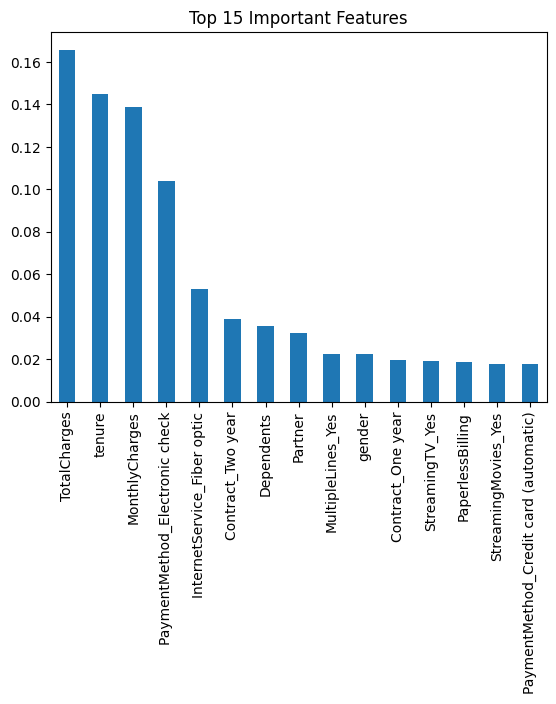

In [14]:
feat_imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
feat_imp.head(15).plot(kind="bar", title="Top 15 Important Features")
